In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
# keras in tensorflow
from tensorflow import keras as K
# tsfnippet
from tfsnippet.modules import Sequential
from tfsnippet.utils import get_variables_as_dict, VariableSaver
# donut
from donut import complete_timestamp, standardize_kpi
from donut import Donut, DonutTrainer, DonutPredictor

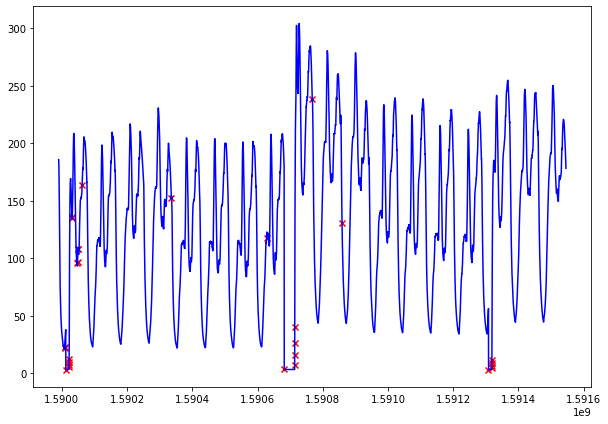

In [2]:
df_series = pd.read_csv('./data/train/0')
df_series['time'] = df_series['time'].apply(lambda x: int(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').timestamp()))
df_alert = df_series[df_series['alert_flag'] == 1]
plt.figure(figsize=(10, 7))
plt.plot(df_series['time'], df_series['value'], color='blue')
plt.scatter(df_alert['time'], df_alert['value'], marker='x', color='red')
plt.show()

In [3]:
timestamp, values, labels = df_series['time'], df_series['value'], df_series['alert_flag']
timestamp, missing, (values, labels) = complete_timestamp(timestamp, (values, labels))

# split the training and testing data
# test_portion = 0.3
# test_n = int(len(values) * test_portion)
# train_values, test_values = values[:-test_n], values[-test_n:]
# train_labels, test_labels = labels[:-test_n], labels[-test_n:]
# train_missing, test_missing = missing[:-test_n], missing[-test_n:]

# test itself
test_n = int(len(values))
train_values, test_values = values, values
train_labels, test_labels = labels, labels
train_missing, test_missing = missing, missing

# standardize the training and testing data
train_values, mean, std = standardize_kpi(train_values, excludes=np.logical_or(train_labels, train_missing))
test_values, _, _ = standardize_kpi(test_values, mean=mean, std=std)
print(test_values)

[0.7674545  0.7615033  0.76068854 ... 0.6665314  0.66369754 0.656967  ]


In [4]:
with tf.variable_scope('model') as model_vs:
    model = Donut(
        h_for_p_x = Sequential([
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001), activation=tf.nn.relu),
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001), activation=tf.nn.relu)
        ]),
        h_for_q_z = Sequential([
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001), activation=tf.nn.relu),
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001), activation=tf.nn.relu)
        ]),
        x_dims = 120,
        z_dims = 5,
    )

0.002155s (±0.001855s); valid time: 0.01795s; loss: -244.286 (±7.22956); valid loss: -285.996
[Epoch 99/256, Step 6900, ETA 35.23s] step time: 0.002223s (±0.002026s); valid time: 0.02028s; loss: -245.844 (±7.68096); valid loss: -282.33
[Epoch 100/256, Step 7000, ETA 34.95s] step time: 0.003036s (±0.01043s); valid time: 0.1037s; loss: -246.709 (±6.33091); valid loss: -287.709 (*)
[Epoch 100/256, Step 7000, ETA 34.95s] Learning rate decreased to 5.631351470947266e-05
[Epoch 102/256, Step 7100, ETA 34.68s] step time: 0.002892s (±0.009344s); valid time: 0.09279s; loss: -244.977 (±7.27134); valid loss: -287.769 (*)
[Epoch 103/256, Step 7200, ETA 34.27s] step time: 0.002102s (±0.001828s); valid time: 0.01795s; loss: -246.942 (±7.25768); valid loss: -286.815
[Epoch 105/256, Step 7300, ETA 34.01s] step time: 0.00292s (±0.009871s); valid time: 0.09804s; loss: -247.514 (±5.99086); valid loss: -287.858 (*)
[Epoch 106/256, Step 7400, ETA 33.73s] step time: 0.00308s (±0.01102s); valid time: 0.1097s

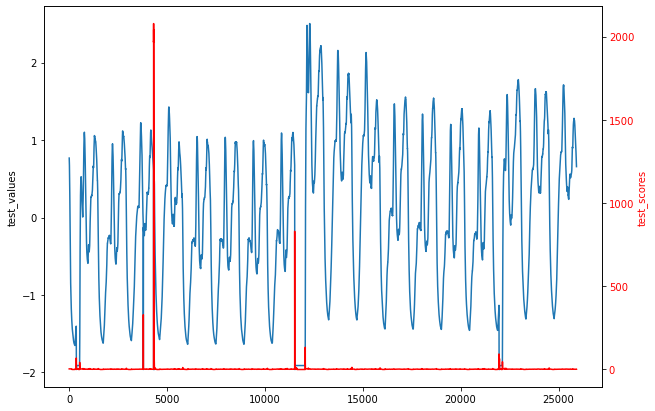

In [5]:
save_dir = '.'

trainer = DonutTrainer(model=model, model_vs=model_vs)
predictor = DonutPredictor(model)

with tf.Session().as_default():
    trainer.fit(train_values, train_labels, train_missing, mean, std)
    test_score = predictor.get_score(test_values, test_missing)

    # save and restore a trained model
    var_dict = get_variables_as_dict(model_vs)
    # save variables to `save_dir`
    saver = VariableSaver(var_dict, save_dir)
    saver.save()

    print('var_dict is:\n{}'.format(var_dict))
    print('saver is:\n{}'.format(saver))

    # check test_value and test_score length

    print(len(test_values))
    print(len(test_score))

    # fix test_score with brute force
    
    test_score = np.concatenate(([0 for i in range(119)], test_score))

    # plot
    
    fig = plt.figure(figsize=(10, 7))
    ax1 = fig.add_subplot(111)
    # ax1.plot(df_series['value'])
    ax1.plot(test_values)
    ax1.set_ylabel('test_values')

    ax2 = ax1.twinx()
    ax2.plot(test_score*-1, 'r-')
    ax2.set_ylabel('test_scores', color='r')
    for i in ax2.get_yticklabels():
        i.set_color('r')